# 가짜연구소 4기 - 추천시스템 톺아보기
## Association Rules
*  UCI Online retail 데이터를 활용한 연관분석
    - 출처: https://archive.ics.uci.edu/ml/datasets/online+retail#

#### Abstract
- This is a transaction data set which contains all the transactions occuring between 01/12/2010 and 09/12/2011 for a UK-based registered non-store online retail

#### Attritbute Information
- InvoiceNo: Invoce number
    - If this code starts with letter 'C', it indicates a cancellation
- StockCode: Product(item) code
- Description: Product(item) name
- Quantity: The quantities of each product (item) per transaction
- InvoceDate: The day and time when each transaction was generated
- UnitPrice: Product price per unit in sterling
- CustomerID: Customer number
- Country: The name of country where each customer resides

## 00. 환경설정

### 00-01. 패키지

In [1]:
%matplotlib inline

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns

### 00-02. 데이터

#### 데이터 불러오기

In [2]:
df = pd.read_csv("../data/online retail.csv")

#### 데이터 확인

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

#### 데이터 변환

In [8]:
df['CustomerID']  = df['CustomerID'].astype('str')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   541909 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


#### `Description` 컬럼 Null 값 존재하므로 주의

In [10]:
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

In [11]:
idx_desc_null = df[df['Description'].isnull()].index.to_list()
idx_desc = df[~df['Description'].isnull()].index.to_list()

len(set(idx_desc_null) & set(idx_desc))

0

In [12]:
df = df.drop(df.index[idx_desc_null])
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [13]:
numeric_col   = [x for x, y in zip(df.dtypes.index, df.dtypes) if y in ['float64', 'int64']]
category_col  = [x for x, y in zip(df.dtypes.index, df.dtypes) if y in ['object']]
date_col      = [x for x, y in zip(df.dtypes.index, df.dtypes) if y in ['datetime64[ns]']]

In [14]:
print("numeric_col : ", numeric_col)
print("category_col : ", category_col)
print("date_col : ", date_col)

numeric_col :  ['Quantity', 'UnitPrice']
category_col :  ['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country']
date_col :  ['InvoiceDate']


## 01. EDA

### InvoiceNo: Invoce number : 환불 데이터 제외
- If this code starts with letter 'C', it indicates a cancellation

In [15]:
idx_c = [i for i, x in zip(df.index, df.InvoiceNo) if x.startswith('C')]
idx_c[:5]

[141, 154, 235, 236, 237]

In [16]:
df.shape

(540455, 8)

In [17]:
df['InvoiceNo'].nunique()

24446

In [18]:
df = df[~df.index.isin(idx_c)].reset_index(drop=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### 01-01. Numeric columns

In [19]:
print(numeric_col)

['Quantity', 'UnitPrice']


In [20]:
df[numeric_col].describe()

,Quantity,UnitPrice
count,531167.000000,531167.000000
mean,10.293623,3.858153
std,159.301358,41.814651
min,-9600.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


#### Quantity: The quantities of each product (item) per transaction

- 환불 데이터를 제외했음에도 수량이 음수인 데이터가 존재 ->  삭제

In [21]:
df[df['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
7187,537032,21275,?,-30,2010-12-03 16:50:00,0.0,nan,United Kingdom
13023,537425,84968F,check,-20,2010-12-06 15:35:00,0.0,nan,United Kingdom
13024,537426,84968E,check,-35,2010-12-06 15:36:00,0.0,nan,United Kingdom
13068,537432,35833G,damages,-43,2010-12-06 16:10:00,0.0,nan,United Kingdom
20971,538072,22423,faulty,-13,2010-12-09 14:10:00,0.0,nan,United Kingdom


In [22]:
df = df[df['Quantity'] >= 0].reset_index(drop=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [23]:
df['Quantity'].describe()

count    530693.000000
mean         10.605819
std         156.637853
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

- **`3분위수와 최댓값의 차이가 심함`**: 아웃라이어

In [24]:
np.percentile(df['Quantity'], 99.9)

478.6160000001546

In [25]:
df.loc[df['Quantity'] > np.percentile(df['Quantity'], 99.9)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
720,536437,17021,NAMASTE SWAGAT INCENSE,600,2010-12-01 12:12:00,0.24,13694.0,United Kingdom
860,536477,21137,BLACK RECORD COVER FRAME,480,2010-12-01 12:27:00,3.39,16210.0,United Kingdom
3875,536736,22616,PACK OF 12 LONDON TISSUES,600,2010-12-02 12:59:00,0.29,17381.0,United Kingdom
4799,536809,84950,ASSORTED COLOUR T-LIGHT HOLDER,1824,2010-12-02 16:48:00,0.55,15299.0,United Kingdom
4863,536830,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2880,2010-12-02 17:38:00,0.18,16754.0,United Kingdom
...,...,...,...,...,...,...,...,...
526712,581375,21137,BLACK RECORD COVER FRAME,960,2011-12-08 12:36:00,3.39,16210.0,United Kingdom
528871,581457,23543,WALL ART KEEP CALM,698,2011-12-08 18:43:00,4.15,18102.0,United Kingdom
528880,581458,22197,POPCORN HOLDER,1500,2011-12-08 18:45:00,0.72,17949.0,United Kingdom
528881,581459,22197,POPCORN HOLDER,1200,2011-12-08 18:46:00,0.72,17949.0,United Kingdom


* 데이터 분포 -> 상위 1%가 엄청 튀는 것을 확인할 수 있음 (Log scaling 적용)

<AxesSubplot:xlabel='percentile', ylabel='quantity'>

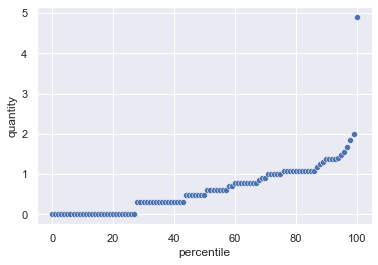

In [26]:
from math import log10

x = []
y = []
for i in range(0, 101) :
    x.append(i)
    y.append(log10(np.percentile(df['Quantity'], i)))
p_qnt_dict = {'percentile' : x, 'quantity' : y}
df_qnt = pd.DataFrame(p_qnt_dict)

sns.set(style='darkgrid')
sns.scatterplot(x='percentile', y='quantity', data=df_qnt)

#### UnitPrice: Product price per unit in sterling

In [27]:
df[numeric_col].describe()

,Quantity,UnitPrice
count,530693.000000,530693.000000
mean,10.605819,3.861599
std,156.637853,41.833162
min,1.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


- 환불 데이터를 제거했음에도 가격이 음수 or 0인 데이터가 존재 -> 삭제

In [28]:
df[df['UnitPrice'] == 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
6299,536941,22734,amazon,20,2010-12-03 12:08:00,0.0,nan,United Kingdom
6300,536942,22139,amazon,15,2010-12-03 12:08:00,0.0,nan,United Kingdom
9161,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany
14117,537534,85064,CREAM SWEETHEART LETTER RACK,1,2010-12-07 11:48:00,0.0,nan,United Kingdom
14118,537534,84832,ZINC WILLIE WINKIE CANDLE STICK,1,2010-12-07 11:48:00,0.0,nan,United Kingdom


In [29]:
df = df[df['UnitPrice'] > 0].reset_index(drop=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [30]:
df[numeric_col].describe()

,Quantity,UnitPrice
count,530104.000000,530104.000000
mean,10.542037,3.907625
std,155.524124,35.915681
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


- **`3분위수와 최댓값의 차이가 심함`**: 아웃라이어

In [31]:
np.percentile(df['UnitPrice'], 99.9)

165.0

In [32]:
df.loc[df['UnitPrice'] > np.percentile(df['UnitPrice'], 99.9)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1801,536544,DOT,DOTCOM POSTAGE,1,2010-12-01 14:32:00,569.77,nan,United Kingdom
3005,536592,DOT,DOTCOM POSTAGE,1,2010-12-01 17:06:00,607.49,nan,United Kingdom
4907,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.00,13145.0,United Kingdom
5358,536862,DOT,DOTCOM POSTAGE,1,2010-12-03 11:13:00,254.43,nan,United Kingdom
5593,536865,DOT,DOTCOM POSTAGE,1,2010-12-03 11:28:00,498.47,nan,United Kingdom
...,...,...,...,...,...,...,...,...
525109,581219,DOT,DOTCOM POSTAGE,1,2011-12-08 09:28:00,1008.96,nan,United Kingdom
525506,581238,DOT,DOTCOM POSTAGE,1,2011-12-08 10:53:00,1683.75,nan,United Kingdom
527589,581439,DOT,DOTCOM POSTAGE,1,2011-12-08 16:30:00,938.59,nan,United Kingdom
529107,581492,DOT,DOTCOM POSTAGE,1,2011-12-09 10:03:00,933.17,nan,United Kingdom


<AxesSubplot:xlabel='percentile', ylabel='unitprice'>

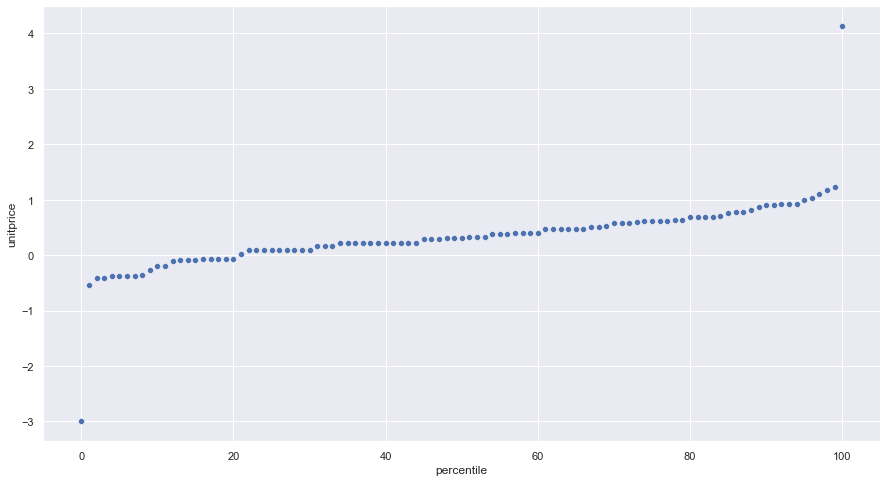

In [33]:
x2 = []
y2 = []
for i in range(0, 101) :
    x2.append(i)
    y2.append(log10(np.percentile(df['UnitPrice'], i)))
p_uprice_dict = {'percentile' : x2, 'unitprice' : y2}
df_uprice = pd.DataFrame(p_uprice_dict)

plt.figure(figsize=(15,8))
sns.set(style='darkgrid')
sns.scatterplot(x='percentile', y='unitprice', data=df_uprice)

### 01-02. Category columns

In [34]:
category_col

['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country']

###  StockCode: Product(item) code

In [35]:
df['StockCode'].nunique()

3922

- 가장 많이 등장하는 StockCode는 85123A
- **`StockCode와 Description은 1대1 매칭되지 않음`**

In [36]:
df[df['StockCode']=='85123A']['Description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER',
       'CREAM HANGING HEART T-LIGHT HOLDER'], dtype=object)

In [37]:
df['StockCode'].value_counts()

85123A      2265
85099B      2112
22423       2017
47566       1706
20725       1595
            ... 
DCGS0004       1
84705C         1
20964          1
72803b         1
23843          1
Name: StockCode, Length: 3922, dtype: int64

In [38]:
df['StockCode'].value_counts().describe()

count    3922.000000
mean      135.161652
std       197.871012
min         1.000000
25%        16.000000
50%        65.000000
75%       169.000000
max      2265.000000
Name: StockCode, dtype: float64

- 가장 많이 팔린 StockCode는 23843

In [39]:
df.groupby(['StockCode']).sum()['Quantity'].reset_index().sort_values(by=['Quantity'], ascending=False)

,StockCode,Quantity
2465,23843,80995
2020,23166,78033
1109,22197,56921
2909,84077,55047
3387,85099B,48474
...,...,...
2447,23643,1
3406,85119,1
2902,84031a,1
2435,23628,1


In [40]:
df[df['StockCode']=='23843']['Description'].unique()

array(['PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

In [41]:
df.groupby(['StockCode', 'Description']).sum().sort_values(by=['StockCode'])

,,Quantity,UnitPrice
StockCode,Description,,
10002,INFLATABLE POLITICAL GLOBE,860,77.15
10080,GROOVY CACTUS INFLATABLE,303,9.04
10120,DOGGY RUBBER,193,6.30
10123C,HEARTS WRAPPING TAPE,5,1.95
10124A,SPOTS ON RED BOOKCOVER TAPE,16,2.10
...,...,...,...
gift_0001_20,Dotcomgiftshop Gift Voucher ?20.00,10,150.38
gift_0001_30,Dotcomgiftshop Gift Voucher ?30.00,7,175.53
gift_0001_40,Dotcomgiftshop Gift Voucher ?40.00,3,100.70


### StockCode - Description 통일작업

* 동일 StockCode이지만 Description 다른 경우, 등장 빈도가 높은 Description으로 통일

In [42]:
stock_desc_dict = {}

df_stockgroup = df.groupby(['StockCode', 'Description']).sum()
for row in df_stockgroup.iterrows() :
    stockcode = row[0][0]
    stockdesc = row[0][1]
    cnt = row[1].Quantity
    
    if stock_desc_dict.get(stockcode) :
        if stock_desc_dict[stockcode][1] < cnt :
            stock_desc_dict[stockcode] = (stockdesc, cnt)
    else :
        stock_desc_dict[stockcode] = (stockdesc, cnt)
            

In [43]:
df['Description'] = df['StockCode'].apply(lambda x : stock_desc_dict[x][0])
#df[df['StockCode']=='85123A']['Description_c'].unique()

## 연관분석 준비

In [44]:
#!pip install mlxtend

In [45]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

invoice_dict = {}

for row in df.itertuples(index = False) :
    item = invoice_dict.get(row.InvoiceNo, {})
    item[row.StockCode] = row.Quantity
    invoice_dict[row.InvoiceNo] = item

In [46]:
invoice_dict['559828']

{'22371': 2}

In [47]:
invoice_ls = []
for invoice_no, item in invoice_dict.items() :
    invoice_ls.append([k for k, v in item.items()])


In [48]:
invoice_ls[:3]

[['85123A', '71053', '84406B', '84029G', '84029E', '22752', '21730'],
 ['22633', '22632'],
 ['84879',
  '22745',
  '22748',
  '22749',
  '22310',
  '84969',
  '22623',
  '22622',
  '21754',
  '21755',
  '21777',
  '48187']]

In [49]:
tr = TransactionEncoder()
tr_matrix = tr.fit(invoice_ls).transform(invoice_ls)

In [50]:
tr_matrix

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [51]:
tr_df = pd.DataFrame(tr_matrix, columns = [stock_desc_dict[x][0] for x in tr.columns_])

In [52]:
tr_df.head()

,INFLATABLE POLITICAL GLOBE,GROOVY CACTUS INFLATABLE,DOGGY RUBBER,HEARTS WRAPPING TAPE,SPOTS ON RED BOOKCOVER TAPE,ARMY CAMO BOOKCOVER TAPE,MINI FUNKY DESIGN TAPES,COLOURING PENCILS BROWN TUBE,COLOURING PENCILS BROWN TUBE,ASSTD DESIGN RACING CAR PEN,...,Manual,PADS TO MATCH ALL CUSHIONS,POSTAGE,SAMPLES,Dotcomgiftshop Gift Voucher ?10.00,Dotcomgiftshop Gift Voucher ?20.00,Dotcomgiftshop Gift Voucher ?30.00,Dotcomgiftshop Gift Voucher ?40.00,Dotcomgiftshop Gift Voucher ?50.00,Manual
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


* 전체 데이터 대상으로 연관분석 시행하게 되면 support값이 대부분 0.1 미만

In [53]:
candidates = apriori(tr_df, min_support=0.1,use_colnames=True)
candidates

,support,itemsets
0,0.104659,(JUMBO BAG RED RETROSPOT)
1,0.110120,(WHITE HANGING HEART T-LIGHT HOLDER)


In [54]:
association_rules(candidates, metric="confidence", min_threshold=0.00005)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


## Apriori - 아이템 필터링
전체 아이템 대상으로 하니 연관성 계산이 잘 안되어, '판매총액'이 작은 아이템은 제외하고 다시 시행

In [55]:
df['Amount'] = df['Quantity'] * df['UnitPrice']
df_totalamount = df.groupby(['StockCode']).sum()['Amount']

In [56]:
df_totalamount.describe()

count      3922.000000
mean       2719.705391
std        7979.946497
min           0.003000
25%         128.840000
50%         685.915000
75%        2233.760000
max      206248.770000
Name: Amount, dtype: float64

In [57]:
stockcode_ppl = df_totalamount.index[df_totalamount >= 2200].tolist() # 판매총액 상위 약 25% 정도 아이템 대상

In [58]:
df_ppl = df[df['StockCode'].isin(stockcode_ppl)]

In [59]:
pd.concat([df.describe(), df_ppl.describe()], axis = 1)

,Quantity,UnitPrice,Amount,Quantity,UnitPrice,Amount
count,530104.000000,530104.000000,530104.000000,357444.000000,357444.000000,357444.000000
mean,10.542037,3.907625,20.121871,11.402978,4.683986,25.232944
std,155.524124,35.915681,270.356743,188.517578,43.663665,328.846067
min,1.000000,0.001000,0.001000,1.000000,0.060000,0.080000
25%,1.000000,1.250000,3.750000,2.000000,1.630000,4.960000
50%,3.000000,2.080000,9.900000,4.000000,2.490000,12.750000
75%,10.000000,4.130000,17.700000,10.000000,4.950000,19.800000
max,80995.000000,13541.330000,168469.600000,80995.000000,13541.330000,168469.600000


In [60]:
invoice_dict_ppl = {}

for row in df_ppl.itertuples(index = False) :
    item = invoice_dict_ppl.get(row.InvoiceNo, {})
    item[row.StockCode] = row.Quantity
    invoice_dict_ppl[row.InvoiceNo] = item

In [61]:
key_singular = [k for k, v in invoice_dict_ppl.items() if len(v) <= 1]
for k in key_singular :
    del invoice_dict_ppl[k]

In [62]:
invoice_ls_ppl = []
for invoice_no, item in invoice_dict_ppl.items() :
    invoice_ls_ppl.append([k for k, v in item.items()])

In [63]:
tr_ppl = TransactionEncoder()
tr_matrix_ppl = tr_ppl.fit(invoice_ls_ppl).transform(invoice_ls_ppl)

In [64]:
tr_df_ppl = pd.DataFrame(tr_matrix_ppl, columns = [stock_desc_dict[x][0] for x in tr_ppl.columns_])
tr_df_ppl.head()

,COLOURING PENCILS BROWN TUBE,ASSTD DESIGN RACING CAR PEN,ASSORTED COLOURS SILK FAN,EDWARDIAN PARASOL BLACK,EDWARDIAN PARASOL NATURAL,EDWARDIAN PARASOL PINK,SMALL CHINESE STYLE SCISSOR,WRAP PINK FAIRY CAKES,WRAP ENGLISH ROSE,BROCADE RING PURSE,...,LADIES & GENTLEMEN METAL SIGN,HAND OVER THE CHOCOLATE SIGN,S/4 CACTI CANDLES,CACTI T-LIGHT CANDLES,VICTORIAN SEWING KIT,S/4 VALENTINE DECOUPAGE HEART BOX,CARRIAGE,DOTCOM POSTAGE,Manual,POSTAGE
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [65]:
candidates_ppl = apriori(tr_df_ppl, min_support=0.1,use_colnames=True)
candidates_ppl

,support,itemsets
0,0.110498,(REGENCY CAKESTAND 3 TIER)
1,0.116806,(JUMBO BAG RED RETROSPOT)
2,0.122437,(WHITE HANGING HEART T-LIGHT HOLDER)


In [66]:
association_rules(candidates_ppl, metric="confidence", min_threshold=0.00001)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


## Apriori - 아이템 필터링2
가격 기준이 아닌 StockCode의 등장 빈도로 cut

In [67]:
stock_counts = df['StockCode'].value_counts()
stock_counts.describe()

count    3922.000000
mean      135.161652
std       197.871012
min         1.000000
25%        16.000000
50%        65.000000
75%       169.000000
max      2265.000000
Name: StockCode, dtype: float64

In [68]:
stockcode_q = stock_counts.index[stock_counts > 1500].tolist()
df_q = df[df['StockCode'].isin(stockcode_q)]

In [69]:
pd.concat([df.describe(), df_q.describe()], axis = 1)

,Quantity,UnitPrice,Amount,Quantity,UnitPrice,Amount
count,530104.000000,530104.000000,530104.000000,9695.000000,9695.000000,9695.000000
mean,10.542037,3.907625,20.121871,14.219804,5.547069,52.489936
std,155.524124,35.915681,270.356743,47.005053,5.020870,143.098913
min,1.000000,0.001000,0.001000,1.000000,1.450000,1.650000
25%,1.000000,1.250000,3.750000,2.000000,2.080000,12.390000
50%,3.000000,2.080000,9.900000,5.000000,2.950000,19.800000
75%,10.000000,4.130000,17.700000,10.000000,5.790000,39.600000
max,80995.000000,13541.330000,168469.600000,1930.000000,32.040000,4921.500000


In [70]:
invoice_dict_q = {}

for row in df_q.itertuples(index = False) :
    item = invoice_dict_q.get(row.InvoiceNo, {})
    item[row.StockCode] = row.Quantity
    invoice_dict_q[row.InvoiceNo] = item

In [71]:
invoice_ls_q = []
for invoice_no, item in invoice_dict_q.items() :
    item_ls = [k for k, v in item.items()]
    if len(item_ls) >= 2 :
        invoice_ls_q.append(item_ls)

In [72]:
tr_q = TransactionEncoder()
tr_matrix_q = tr_q.fit(invoice_ls_q).transform(invoice_ls_q)

In [73]:
tr_df_q = pd.DataFrame(tr_matrix_q, columns = [stock_desc_dict[x][0] for x in tr_q.columns_])
tr_df_q.head()

,LUNCH BAG RED RETROSPOT,REGENCY CAKESTAND 3 TIER,PARTY BUNTING,JUMBO BAG RED RETROSPOT,WHITE HANGING HEART T-LIGHT HOLDER
0,False,False,False,True,True
1,True,False,False,False,True
2,False,True,False,False,True
3,False,False,False,True,True
4,True,True,False,True,True


In [74]:
candidates_q = apriori(tr_df_q, min_support=0.05,use_colnames=True)
print("num of candidate list : ", len(candidates_q))
candidates_q.head()

num of candidate list :  23


,support,itemsets
0,0.488515,(LUNCH BAG RED RETROSPOT)
1,0.417050,(REGENCY CAKESTAND 3 TIER)
2,0.459929,(PARTY BUNTING)
3,0.532414,(JUMBO BAG RED RETROSPOT)
4,0.484431,(WHITE HANGING HEART T-LIGHT HOLDER)


In [75]:
association_rules(candidates_q, metric="confidence", min_threshold=0.4)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(JUMBO BAG RED RETROSPOT),(LUNCH BAG RED RETROSPOT),0.532414,0.488515,0.295559,0.555129,1.136362,0.035467,1.149740
1,(LUNCH BAG RED RETROSPOT),(JUMBO BAG RED RETROSPOT),0.488515,0.532414,0.295559,0.605016,1.136362,0.035467,1.183808
2,(PARTY BUNTING),(REGENCY CAKESTAND 3 TIER),0.459929,0.417050,0.201633,0.438402,1.051198,0.009821,1.038021
3,(REGENCY CAKESTAND 3 TIER),(PARTY BUNTING),0.417050,0.459929,0.201633,0.483476,1.051198,0.009821,1.045589
4,(REGENCY CAKESTAND 3 TIER),(WHITE HANGING HEART T-LIGHT HOLDER),0.417050,0.484431,0.178663,0.428397,0.884330,-0.023369,0.901970
5,(WHITE HANGING HEART T-LIGHT HOLDER),(PARTY BUNTING),0.484431,0.459929,0.199081,0.410959,0.893528,-0.023722,0.916866
6,(PARTY BUNTING),(WHITE HANGING HEART T-LIGHT HOLDER),0.459929,0.484431,0.199081,0.432852,0.893528,-0.023722,0.909056
7,(WHITE HANGING HEART T-LIGHT HOLDER),(JUMBO BAG RED RETROSPOT),0.484431,0.532414,0.203165,0.419389,0.787711,-0.054753,0.805333
8,"(PARTY BUNTING, LUNCH BAG RED RETROSPOT)",(REGENCY CAKESTAND 3 TIER),0.162838,0.417050,0.067892,0.416928,0.999708,-0.000020,0.999791
9,"(REGENCY CAKESTAND 3 TIER, LUNCH BAG RED RETRO...",(PARTY BUNTING),0.141399,0.459929,0.067892,0.480144,1.043954,0.002858,1.038887


### FP-Growth

* 아이템 필터링(판매총액)에서 사용했던 tr_df_ppl을 사용

In [76]:
from mlxtend.frequent_patterns import fpgrowth

candidates_fp = fpgrowth(tr_df_ppl, min_support = 0.01, use_colnames=True)
print("num of candidate list : ", len(candidates_fp))
candidates_fp.head()

num of candidate list :  2615


,support,itemsets
0,0.122437,(WHITE HANGING HEART T-LIGHT HOLDER)
1,0.025850,(KNITTED UNION FLAG HOT WATER BOTTLE)
2,0.023992,(RED WOOLLY HOTTIE WHITE HEART.)
3,0.021345,(SET 7 BABUSHKA NESTING BOXES)
4,0.018754,(WHITE METAL LANTERN)


In [77]:
ar_result = association_rules(candidates_fp, metric="confidence", min_threshold=0.4)
ar_result.sort_values(by=['lift'], ascending=False, inplace=True)
ar_result.reset_index(drop=True, inplace=True)
ar_result

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(GREEN REGENCY TEACUP AND SAUCER, REGENCY TEA ...","(REGENCY TEA PLATE GREEN , ROSES REGENCY TEACU...",0.012615,0.012841,0.010250,0.812500,63.275219,0.010088,5.264849
1,"(REGENCY TEA PLATE GREEN , ROSES REGENCY TEACU...","(GREEN REGENCY TEACUP AND SAUCER, REGENCY TEA ...",0.012841,0.012615,0.010250,0.798246,63.275219,0.010088,4.893993
2,"(REGENCY TEA PLATE ROSES , ROSES REGENCY TEACU...","(GREEN REGENCY TEACUP AND SAUCER, REGENCY TEA ...",0.015488,0.013686,0.010250,0.661818,48.359027,0.010038,2.916521
3,"(GREEN REGENCY TEACUP AND SAUCER, REGENCY TEA ...","(REGENCY TEA PLATE ROSES , ROSES REGENCY TEACU...",0.013686,0.015488,0.010250,0.748971,48.359027,0.010038,3.921910
4,(REGENCY SUGAR BOWL GREEN),"(REGENCY MILK JUG PINK , REGENCY TEAPOT ROSES )",0.018135,0.012728,0.010870,0.599379,47.091024,0.010639,2.464353
...,...,...,...,...,...,...,...,...,...
2228,"(CHARLOTTE BAG PINK POLKADOT, RED RETROSPOT CH...",(JUMBO BAG RED RETROSPOT),0.029399,0.116806,0.012165,0.413793,3.542580,0.008731,1.506626
2229,(RED RETROSPOT CHARLOTTE BAG),(JUMBO BAG RED RETROSPOT),0.058065,0.116806,0.023936,0.412221,3.529122,0.017153,1.502596
2230,"(LUNCH BAG VINTAGE DOILY , LUNCH BAG RED RETRO...",(JUMBO BAG RED RETROSPOT),0.026019,0.116806,0.010701,0.411255,3.520854,0.007661,1.500132
2231,(FLORAL FOLK STATIONERY SET),(WHITE HANGING HEART T-LIGHT HOLDER),0.023936,0.122437,0.010137,0.423529,3.459148,0.007207,1.522302


### 추천

* antecedents에서 아이템 명을 검색하여 lift 높은 순으로 출력

In [78]:
test_item = ['FLORAL FOLK STATIONERY SET']
ar_result[(ar_result['antecedents'] == set(test_item))].sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
151,(FLORAL FOLK STATIONERY SET),(MODERN FLORAL STATIONERY SET),0.023936,0.020613,0.012052,0.503529,24.428055,0.011559,1.972699
225,(FLORAL FOLK STATIONERY SET),(VINTAGE PAISLEY STATIONERY SET),0.023936,0.024499,0.012559,0.524706,21.417650,0.011973,2.052416
656,(FLORAL FOLK STATIONERY SET),(DOTCOM POSTAGE),0.023936,0.039592,0.012953,0.541176,13.668747,0.012006,2.093196
2159,(FLORAL FOLK STATIONERY SET),(POPCORN HOLDER),0.023936,0.076988,0.010025,0.418824,5.440110,0.008182,1.588178
2221,(FLORAL FOLK STATIONERY SET),(JUMBO BAG RED RETROSPOT),0.023936,0.116806,0.010475,0.437647,3.746799,0.007680,1.570534
2231,(FLORAL FOLK STATIONERY SET),(WHITE HANGING HEART T-LIGHT HOLDER),0.023936,0.122437,0.010137,0.423529,3.459148,0.007207,1.522302
